# Implement a simple NN to predict largely imbalanced credit card fraud dataset

In [1]:
# largely inspired and guided from
# https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

In [3]:
# Imported Libraries
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Very unbalanced
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


For this very unbalanced data, need to create a subsample with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

Addtionally, there is the need to scale the other two features: time and amount. Using sklearn for that.

In [6]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [7]:
# Saving the dataframe with scaled values, just in case
df.to_csv('creditcard-scaled.csv')

In [66]:
# creating the subsample
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
subsample_df = normal_distributed_df.sample(frac=1, random_state=42)

subsample_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
229565,4.712080,0.719910,1.204097,-1.332319,-1.254583,1.671077,0.558645,2.207111,-0.206006,0.466127,...,0.554946,0.213694,-0.093479,0.053474,-0.832914,-0.946754,2.167932,-0.205154,-0.030317,0
15736,1.089779,-0.675866,-23.914101,13.765942,-25.733734,6.290918,-17.784824,-4.572498,-17.390764,15.794136,...,1.640037,1.773399,-1.748426,-1.093104,0.147807,1.663792,-0.221024,1.458076,0.430315,1
111962,-0.294977,-0.143787,-0.975996,1.490036,1.411660,-0.235850,-0.077866,-0.917928,0.861223,-0.241528,...,0.544970,-0.370196,-0.647655,-0.023048,0.343785,-0.071004,0.057249,0.415209,0.078879,0
8335,-0.293440,-0.864214,-1.426623,4.141986,-9.804103,6.666273,-4.749527,-2.073129,-10.089931,2.791345,...,1.410678,1.865679,0.407809,0.605809,-0.769348,-1.746337,0.502040,1.977258,0.711607,1
42549,0.925452,-0.511578,-5.314173,4.145944,-8.532522,8.344392,-5.718008,-3.043536,-10.989185,3.404129,...,1.150017,2.331466,0.862996,-0.614453,0.523648,-0.712593,0.324638,2.245091,0.497321,1


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


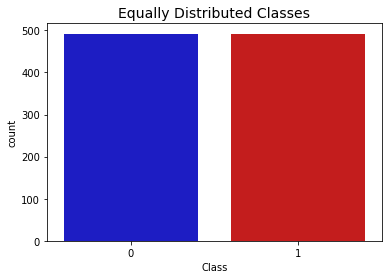

In [10]:
print('Distribution of the Classes in the subsample dataset')
print(subsample_df['Class'].value_counts()/len(subsample_df))

colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=subsample_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [11]:
# Saving the subset dataframe for google AutoML
subsample_df.to_csv('creditcard-subset-distributed.csv')

## Quickly checking the most influential features (aka correlation matrices)
V17, V14, V12 and V10 are negatively correlated. V2, V4, V11, and V19 are positively correlated. 

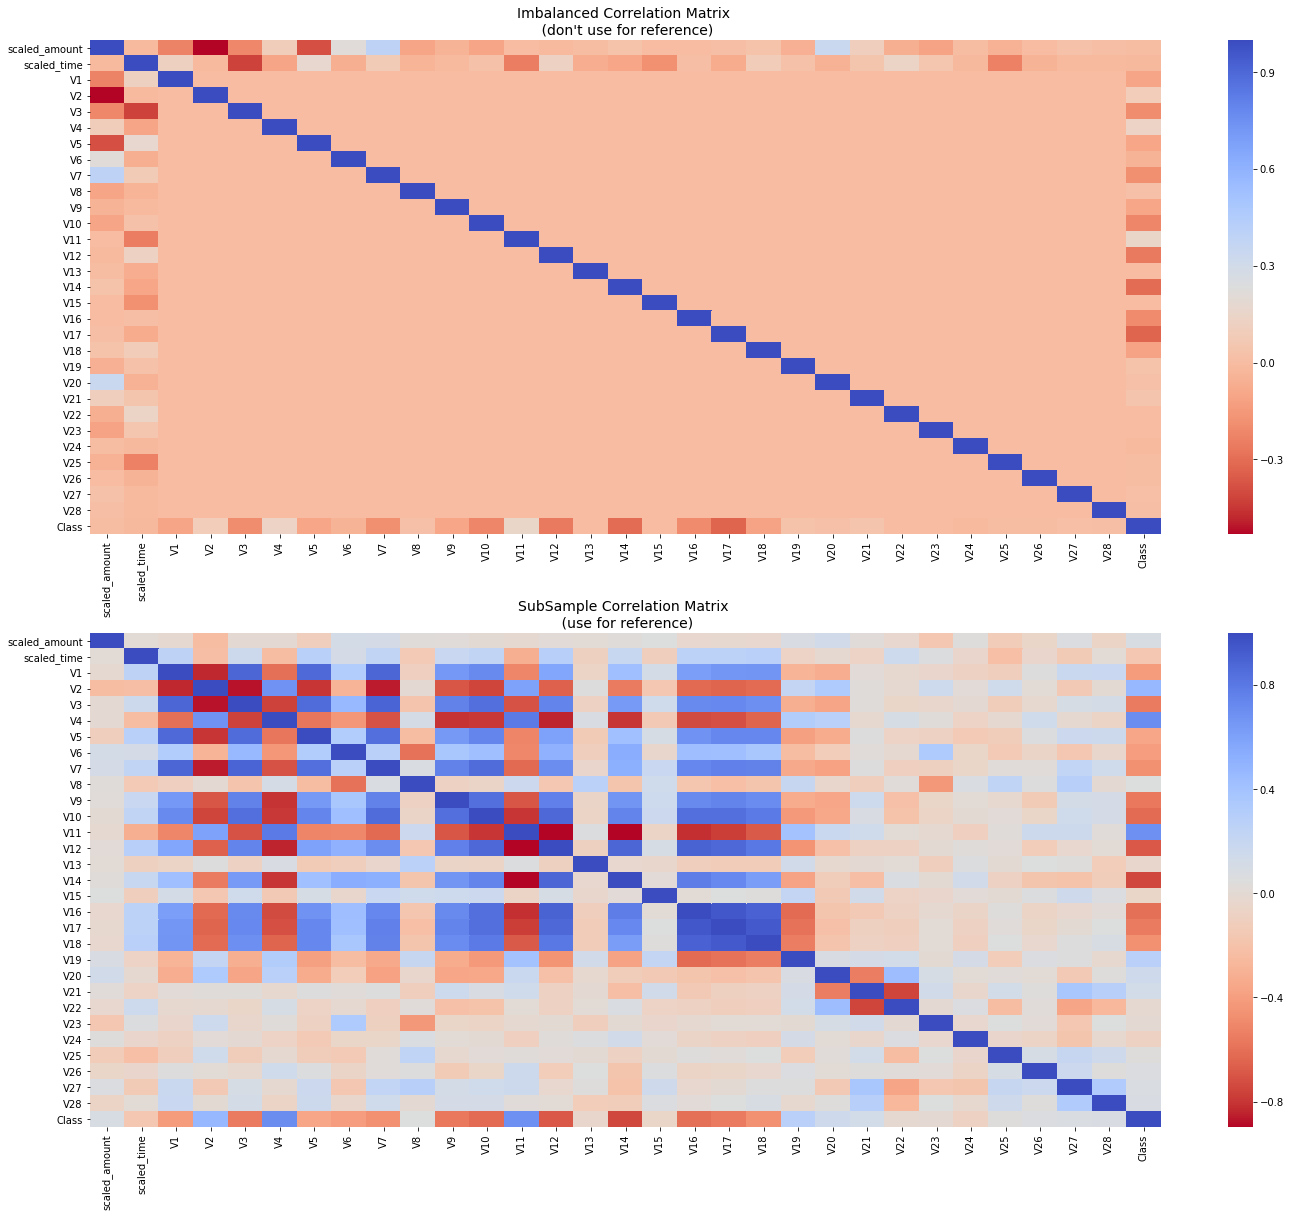

In [62]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = subsample_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

Let's check if a simple neural network behaves in both the random undersample (subsample_df) and oversample dataframes and see whether they can predict accuractely both non-fraud and fraud cases. Let's leverage a confusion matrix.

Confusion matrix:

* Upper Left Square: The amount of correctly classified by our model of no fraud transactions.
* Upper Right Square: The amount of incorrectly classified transactions as fraud cases, but the actual label is no fraud .
* Lower Left Square: The amount of incorrectly classified transactions as no fraud cases, but the actual label is fraud .
* Lower Right Square: The amount of correctly classified by our model of fraud transactions.


In [13]:
# subset_df is from the random undersample data (fewer instances) aka subset
X = subsample_df.drop('Class', axis=1)
y = subsample_df['Class']

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Using TensorFlow backend.


In [15]:
undersample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [16]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
hist = undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 629 samples, validate on 158 samples
Epoch 1/20
 - 0s - loss: 0.0232 - acc: 0.9936 - val_loss: 0.3088 - val_acc: 0.9430
Epoch 2/20
 - 0s - loss: 0.0219 - acc: 0.9936 - val_loss: 0.3172 - val_acc: 0.9430
Epoch 3/20
 - 0s - loss: 0.0206 - acc: 0.9952 - val_loss: 0.3195 - val_acc: 0.9430
Epoch 4/20
 - 0s - loss: 0.0195 - acc: 0.9952 - val_loss: 0.3314 - val_acc: 0.9430
Epoch 5/20
 - 0s - loss: 0.0186 - acc: 0.9952 - val_loss: 0.3384 - val_acc: 0.9430
Epoch 6/20
 - 0s - loss: 0.0177 - acc: 0.9952 - val_loss: 0.3441 - val_acc: 0.9430
Epoch 7/20
 - 0s - loss: 0.0167 - acc: 0.9968 - val_loss: 0.3517 - val_acc: 0.9430
Epoch 8/20
 - 0s - loss: 0.0172 - acc: 0.9952 - val_loss: 0.3509 - val_acc: 0.9430
Epoch 9/20
 - 0s - loss: 0.0159 - acc: 0.9984 - val_loss: 0.3564 - val_acc: 0.9430
Epoch 10/20
 - 0s - loss: 0.0143 - acc: 0.9984 - val_loss: 0.3628 - val_acc: 0.9430
Epoch 11/20
 - 0s - loss: 0.0155 - acc: 0.9968 - val_loss: 0.3537 - val_acc: 0.9430
Epoch 12/20
 - 0s - loss: 0.0136 - acc:

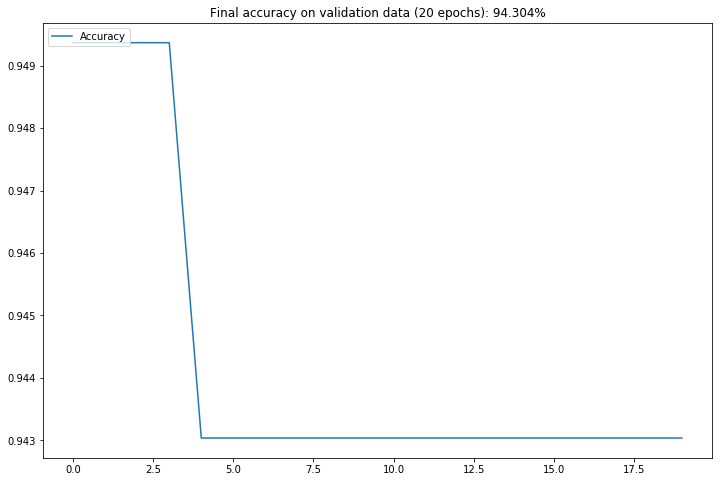

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure(figsize=(12,8))
plt.plot(hist.history['val_acc'], label='Accuracy')
plt.title("Final accuracy on validation data (20 epochs): {:.3%}".format(hist.history['val_acc'][-1:][0]))
plt.legend(loc=2)
_ = plt.show()

## Setting up parameters for the prediction - split the oversample using StratifiedKFold

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 54677  55187  56165 ... 284804 284805 284806] Test: [    0     1     2 ... 56962 56963 56964]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 54677  55187  56165 ... 113921 114104 114607]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113922 113923 113924 ... 170893 170894 170895]
Train: [     0      1      2 ... 284804 284805 284806] Test: [163864 164807 164989 ... 227853 227854 227855]
Train: [     0      1      2 ... 227853 227854 227855] Test: [223435 224368 225054 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


## Getting the predictions with undersample

In [38]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=400, verbose=2)

In [39]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=400, verbose=2)

## Creating the confusion matrix

In [41]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[54381  2482]
 [    4    94]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


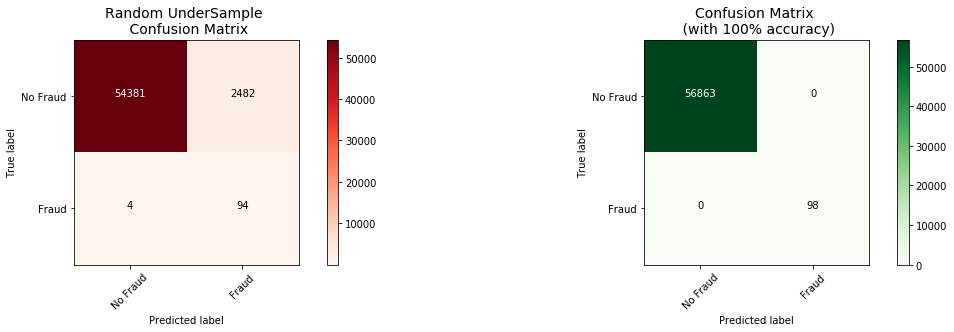

In [42]:
from sklearn.metrics import confusion_matrix

undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

## SMOTE Calculation (not used for comparison with Google AutoML)

In [63]:
from imblearn.over_sampling import SMOTE

# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [64]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 3s - loss: 0.0645 - acc: 0.9758 - val_loss: 0.0218 - val_acc: 0.9985
Epoch 2/20
 - 2s - loss: 0.0127 - acc: 0.9971 - val_loss: 0.0123 - val_acc: 0.9985
Epoch 3/20
 - 2s - loss: 0.0072 - acc: 0.9986 - val_loss: 0.0052 - val_acc: 0.9998
Epoch 4/20
 - 2s - loss: 0.0051 - acc: 0.9991 - val_loss: 0.0059 - val_acc: 0.9997
Epoch 5/20
 - 2s - loss: 0.0042 - acc: 0.9993 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 6/20
 - 2s - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 7/20
 - 3s - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0053 - val_acc: 0.9991
Epoch 8/20
 - 2s - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 9/20
 - 2s - loss: 0.0031 - acc: 0.9995 - val_loss: 2.1941e-04 - val_acc: 1.0000
Epoch 10/20
 - 2s - loss: 0.0025 - acc: 0.9996 - val_loss: 6.8718e-04 - val_acc: 1.0000
Epoch 11/20
 - 2s - loss: 0.0021 - acc: 0.9996 - val_loss: 9.9775e-04 - val_acc: 1.0000
Epoch 12/20
 - 2s - lo

Confusion matrix, without normalization
[[56816    47]
 [   19    79]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


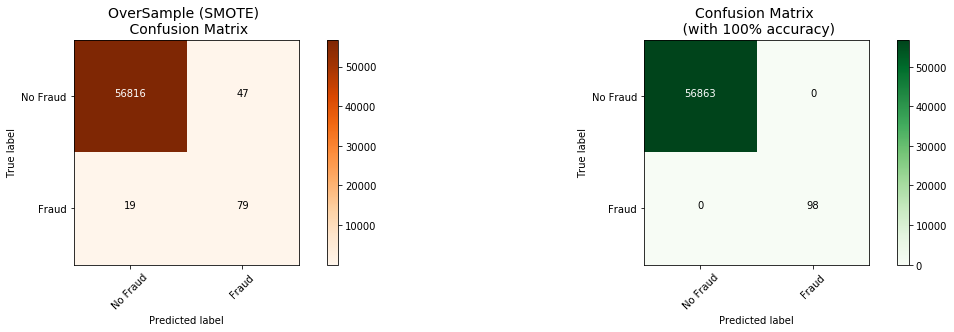

In [65]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)